Post Train RNN
Banco de dados NOrmalizado com incerteças

In [375]:
#pip install darts

In [376]:
#pip install plotting

In [377]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import os
sys.path.append("../") # go to parent dir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from darts import TimeSeries
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta
from darts.metrics import mae, rmse, r2_score
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_hist
from darts.utils.statistics import plot_residuals_analysis
from darts.utils import timeseries_generation as tg

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    RegressionModel
)

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data teste and models

In [378]:
DT = pd.read_excel('DN_opti3.xlsx', index_col=0)
DT.index = pd.to_datetime(DT.index)
DT

,f,Zc,pbh,pwh,q,fq,Zc.1,Pin,H,P,I,qc,5
1970-01-01 00:00:00.000000000,0.000000,0.000000,0.889340,0.814057,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.014289
1970-01-01 00:00:00.000000001,0.037599,0.026043,0.999748,0.930388,0.038404,0.078205,0.047421,0.979137,0.055676,0.029149,0.030457,0.094911,0.000000
1970-01-01 00:00:00.000000002,0.075198,0.052086,1.000000,0.978122,0.111745,0.146292,0.090086,0.948840,0.079480,0.063908,0.057349,0.164376,0.022807
1970-01-01 00:00:00.000000003,0.112797,0.078130,0.966249,0.990766,0.156046,0.214018,0.127513,0.929732,0.118654,0.090555,0.086191,0.199227,0.056064
1970-01-01 00:00:00.000000004,0.150396,0.104173,0.917540,0.997514,0.226758,0.283980,0.165458,0.894301,0.140552,0.121426,0.123674,0.240155,0.089521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000745,1.000000,0.925614,0.252962,0.915168,0.755773,0.988177,0.786462,0.027231,0.978613,0.992419,0.990755,0.981742,0.981623
1970-01-01 00:00:00.000000746,1.000000,0.925614,0.268123,0.917801,0.747694,0.986304,0.786698,0.024750,0.984314,0.987135,0.991015,0.988228,0.961908
1970-01-01 00:00:00.000000747,1.000000,0.925614,0.275187,0.914028,0.760218,0.987702,0.786552,0.036446,0.976953,0.992758,0.990818,0.979461,0.963020
1970-01-01 00:00:00.000000748,1.000000,0.925614,0.247276,0.913373,0.749980,0.990761,0.786121,0.024965,0.984067,0.992326,0.991578,0.976953,0.986014


In [379]:
#train DATA
split = .5
n = len(DT)
input_df = DT[0:int(n)] #100% 
input_df = input_df.transpose()
input_df = input_df.drop(['pbh','pwh','fq','Zc.1','I','qc','P','f','Zc'])
input_df = input_df[:-1]
input_df = input_df.transpose()
input_df 
input_TS = TimeSeries.from_dataframe(input_df) 
#input_TS['Pin'].plot()
target_train_input, target_val_input = input_TS.split_after(split)
len(target_val_input)

375

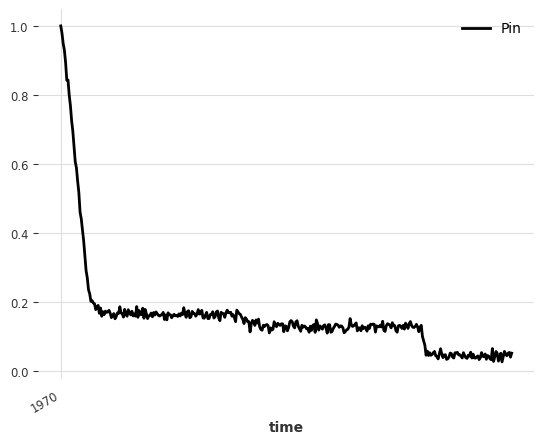

In [380]:
target_train_input['Pin'].plot()

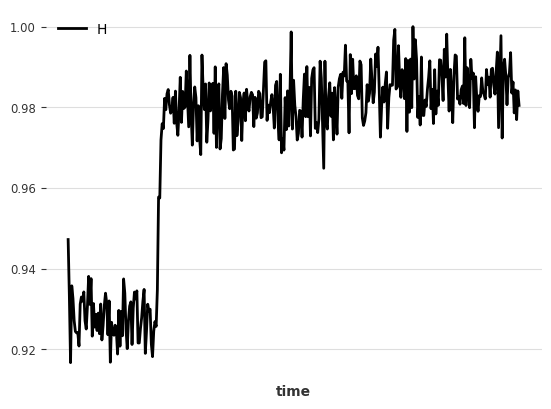

In [381]:
target_val_input['H'].plot()

Separate F and Zc

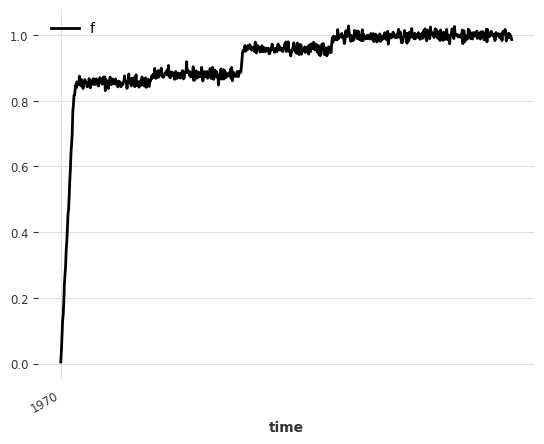

In [382]:
NOISE_DISTANCE = 0.01
SAMPLE_SIZE = len(input_TS)
np.random.seed(42)
noise = tg.gaussian_timeseries(length=SAMPLE_SIZE, std=NOISE_DISTANCE)

f_df = DT[0:int(n)] #100%
f_df = f_df.transpose()
f_df = f_df.drop(['pbh','pwh','fq','Zc.1','I','qc','P','Zc','H','Pin','q'])
f_df = f_df[:-1]
f_df = f_df.transpose()
f_df
f_TS = TimeSeries.from_dataframe(f_df) 
f_TS = f_TS + noise
f_TS.plot()
covf_train_input, covf_val_input = f_TS.split_after(split)

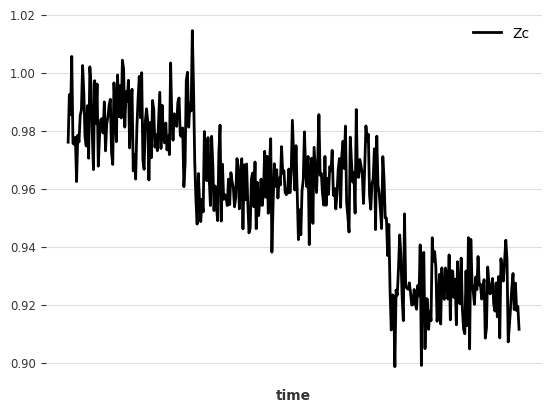

In [383]:
Zc_df = DT[0:int(n)] #100%
Zc_df = Zc_df.transpose()
Zc_df = Zc_df.drop(['pbh','pwh','fq','Zc.1','I','qc','P','f','H','Pin','q'])
Zc_df = Zc_df[:-1]
Zc_df = Zc_df.transpose()
#Zc_df
Zc_TS = TimeSeries.from_dataframe(Zc_df) 
Zc_TS = Zc_TS + noise
#Zc_TS.plot()
covZc_train_input, covZc_val_input = Zc_TS.split_after(split)
covZc_val_input.plot()

Load RN trainig models

In [384]:
model_NB = NBEATSModel.load("NBEATSModel_bcs_control.pt")

In [385]:
model_NB.fit(
    target_train_input,
    past_covariates = covf_train_input.stack(covZc_train_input),
    verbose = False,
    epochs = 100
)
#model_NB.extreme_lags

In [386]:
def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series= input_TS, 
                                          past_covariates= f_TS.stack(Zc_TS),
                                          start= split, 
                                          retrain=False,
                                          verbose=False, 
                                          forecast_horizon=10)
    
    target_val_input[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(input_TS, backtest)))
    return backtest

In [387]:
def pred_model(model):
    pred_series = model.predict(n=10,past_covariates=f_TS.stack(Zc_TS))
    plt.figure(figsize=(8, 5))
    input_TS.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("rmse: {:.2f}%".format(rmse(pred_series, target_val_input)))
    plt.legend()
    return pred_series

Backtest RMSE = 0.07184559960719204


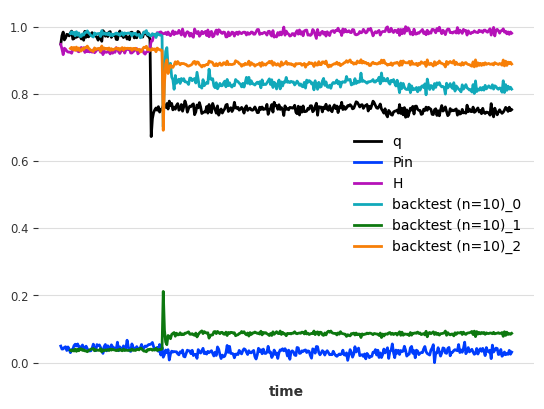

In [388]:
pred_series_NB = eval_model(model_NB)


In [389]:
pred_series_NB
df_Model_NB = pred_series_NB.pd_dataframe()
df_Model_NB
#e1 = rmse(pred_series_NB, target_val_input)
#e1
e1 = rmse(target_val_input,pred_series_NB)
print(e1)
e2 = mae( target_val_input,pred_series_NB)
print(e2)
e3 = r2_score(target_val_input,pred_series_NB)
print(e3)

0.07184559960719204
0.06359650457027353
-11.7182767323636


In [390]:
df_Model_NB = pred_series_NB.pd_dataframe()
#df_Model_NB
df_Target = target_val_input.pd_dataframe()
df_Target 

component,q,Pin,H
time,,,
1970-01-01 00:00:00.000000375,0.948255,0.049265,0.947239
1970-01-01 00:00:00.000000376,0.973211,0.040331,0.933376
1970-01-01 00:00:00.000000377,0.983842,0.040784,0.916733
1970-01-01 00:00:00.000000378,0.960367,0.045445,0.935775
1970-01-01 00:00:00.000000379,0.966262,0.047239,0.932663
...,...,...,...
1970-01-01 00:00:00.000000745,0.755773,0.027231,0.978613
1970-01-01 00:00:00.000000746,0.747694,0.024750,0.984314
1970-01-01 00:00:00.000000747,0.760218,0.036446,0.976953


367

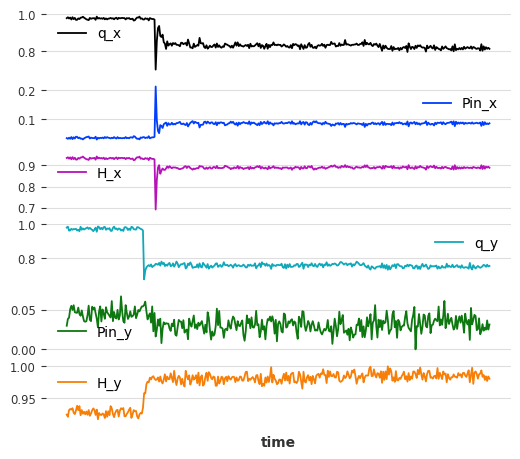

In [391]:
df_Model_NB = pred_series_NB.pd_dataframe()

df_Target = target_val_input.pd_dataframe()
df_Target 
#df_1 = df_Target.iloc[:10,:]
#df_2 = df_Target.iloc[10:,:]
#df_1.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_1 = pd.merge(df_Model_NB, df_Target, on ='time')
df_M_1.plot(subplots=True, figsize=(6, 6))
df_M_1.rename(columns = {'q_x': 'q_Pred', 'Pin_x': 'Pin_Pred', 'H_x': 'H_Pred', 'q_y': 'q_Val', 'Pin_y': 'Pin_Val', 'H_y': 'H_Val'}, inplace = True)
df_M_1['q_err'] = df_M_1['q_Pred'] - df_M_1['q_Val']
df_M_1['Pin_err'] = df_M_1['Pin_Pred'] - df_M_1['Pin_Val']
df_M_1['H_err'] = df_M_1['H_Pred'] - df_M_1['H_Val']
df_M_1 = df_M_1.reset_index(drop=True)
df_M_1
len(df_M_1)

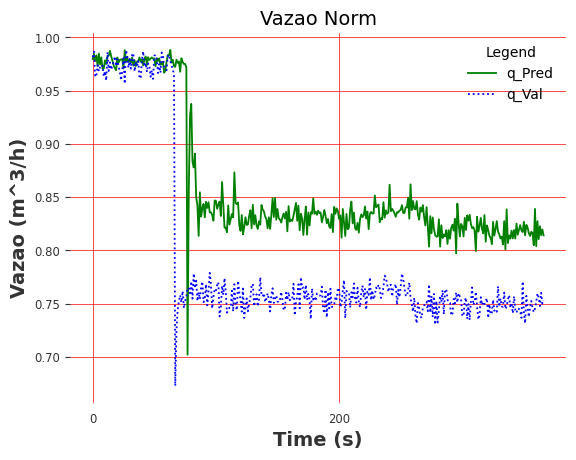

In [392]:
#plot each series
plt.plot(df_M_1['q_Pred'], label='q_Pred', color='green')
plt.plot(df_M_1['q_Val'], label='q_Val', color='blue', linestyle=':')
# adding title to the plot
plt.title('Vazao Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Vazao (m^3/h)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 200))
plt.show()

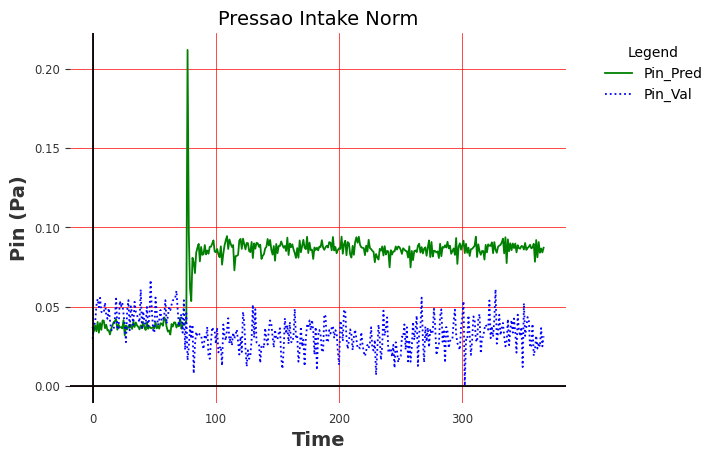

In [393]:
#plot each series
plt.plot(df_M_1['Pin_Pred'], label='Pin_Pred', color='green')
plt.plot(df_M_1['Pin_Val'], label='Pin_Val', color='blue',linestyle=':')
# adding title to the plot
plt.title('Pressao Intake Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time',fontsize=14)
plt.ylabel('Pin (Pa)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.3,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 100))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

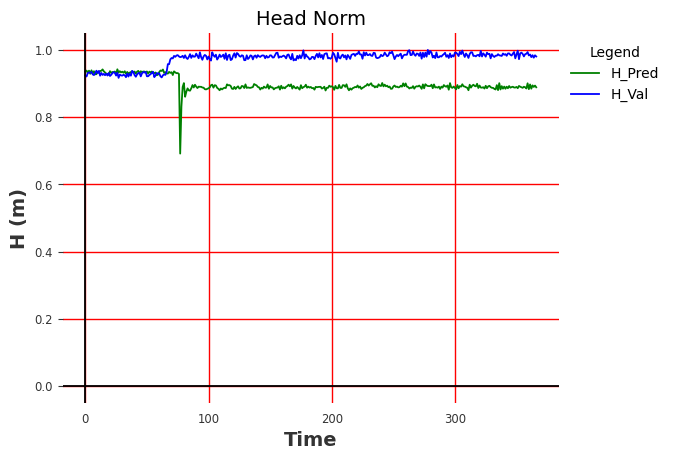

In [394]:
#plot each series
plt.plot(df_M_1['H_Pred'], label='H_Pred', color='green')
plt.plot(df_M_1['H_Val'], label='H_Val', color='blue')
# adding title to the plot
plt.title('Head Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time',fontsize=14)
plt.ylabel('H (m)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=1)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 100))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

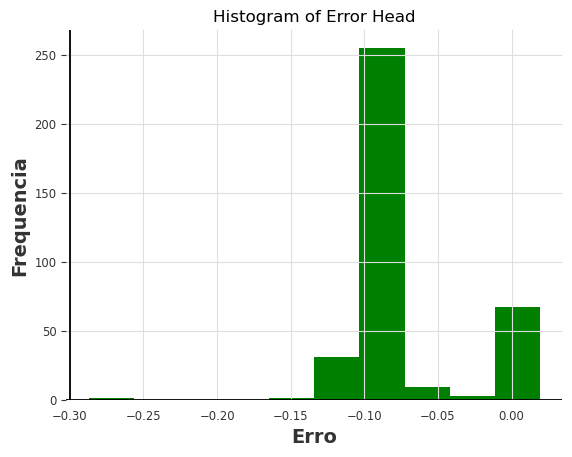

In [437]:
plt.hist(df_M_1['H_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Head')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.3) #y-axis line
plt.show() 

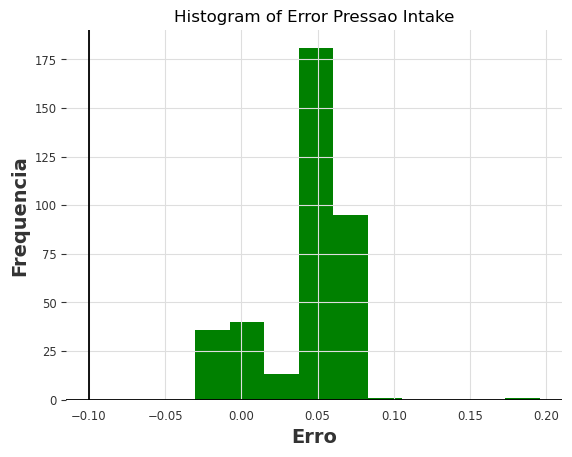

In [438]:
plt.hist(df_M_1['Pin_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Pressao Intake')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.1) #y-axis line
plt.show() 

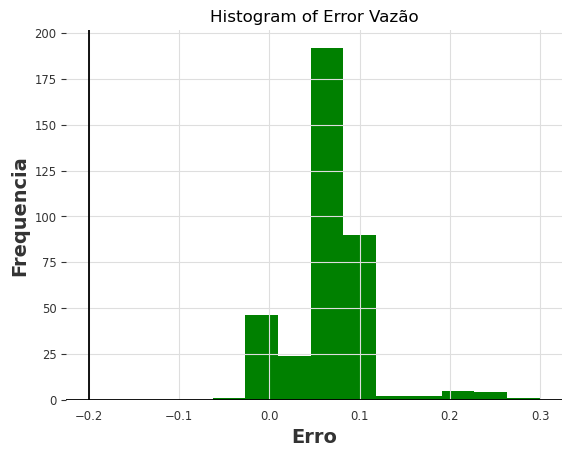

In [439]:
plt.hist(df_M_1['q_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Vazão')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.2) #y-axis line
plt.show() 

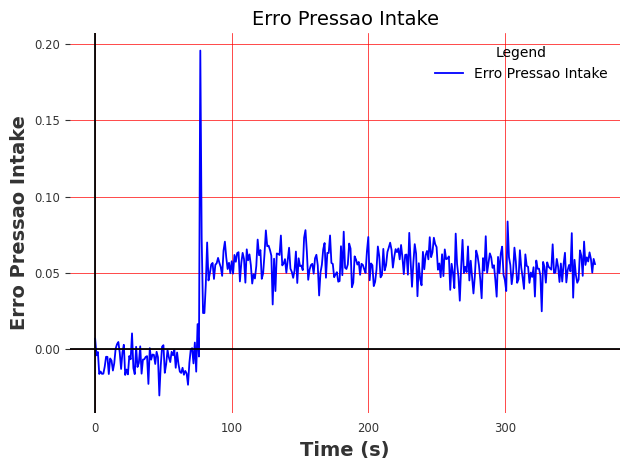

In [398]:
plt.plot(df_M_1['Pin_err'], label='Erro Pressao Intake', color='blue')
# adding title to the plot
plt.title('Erro Pressao Intake',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Pressao Intake',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

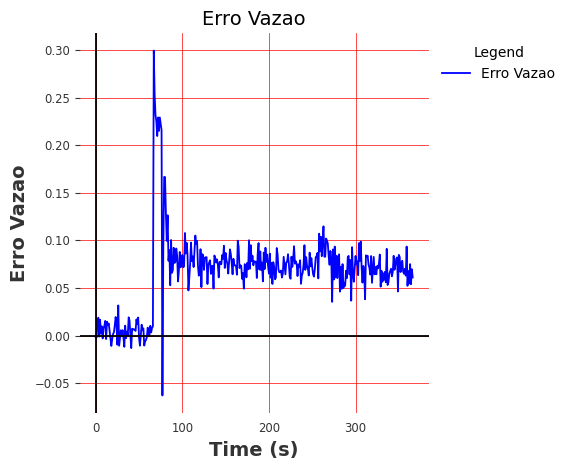

In [399]:
plt.plot(df_M_1['q_err'], label='Erro Vazao', color='blue')
# adding title to the plot
plt.title('Erro Vazao',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Vazao',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.4,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

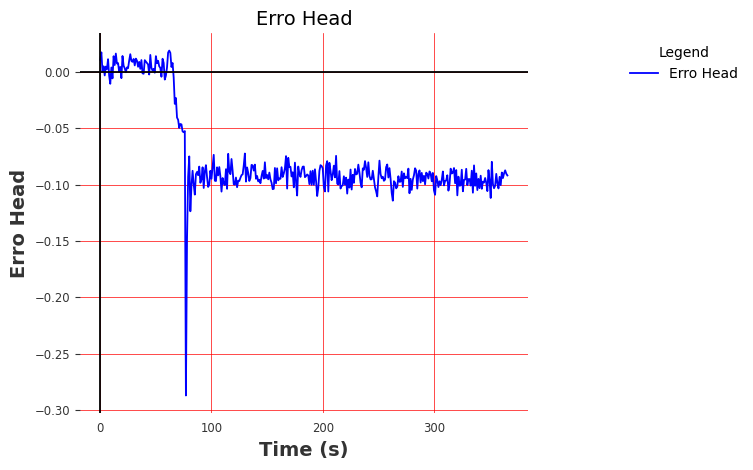

In [400]:
plt.plot(df_M_1['H_err'], label='Erro Head', color='blue')
# adding title to the plot
plt.title('Erro Head',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Head',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

GRU.....LSTM .....RNN

In [454]:
model_BRNN = BlockRNNModel.load("my_model_GRU_control_v2.pt")
#model_BRNN = BlockRNNModel.load("my_model_LSTM_control_v3.pt") 
#model_BRNN = BlockRNNModel.load("my_model_RNN_control_v1.pt") 

In [455]:
model_BRNN.fit(
    target_train_input,
    #val_series = target_val_input,
    past_covariates = covf_train_input.stack(covZc_train_input),
    verbose = False
)

Backtest RMSE = 0.050841008364124425


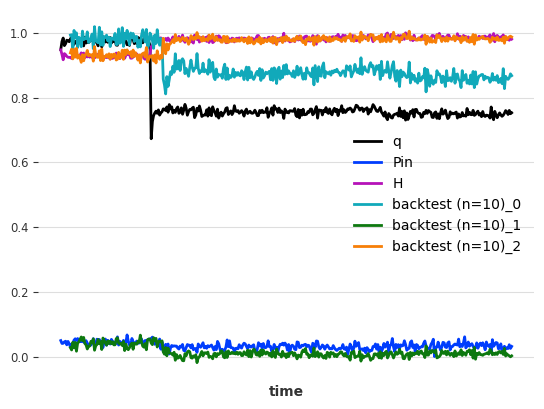

In [456]:
pred_series_BRNN = eval_model(model_BRNN)

In [457]:
#model_BRNN.extreme_lags
e4 = rmse(target_val_input, pred_series_BRNN)
print(e4)
e5 = mae(target_val_input, pred_series_BRNN)
print(e5)
e6 = r2_score(target_val_input, pred_series_BRNN)
print(e6)

0.050841008364124425
0.04466042515914039
-1.4050072341446558


component,q_Pred,Pin_Pred,H_Pred,q_Val,Pin_Val,H_Val,q_err,Pin_err,H_err
0,0.992989,0.027319,0.938120,0.981376,0.029714,0.924193,0.011612,-0.002395,0.013927
1,0.994024,0.020319,0.949566,0.986706,0.038321,0.920848,0.007318,-0.018002,0.028717
2,0.940720,0.043991,0.919406,0.962814,0.039911,0.931237,-0.022095,0.004081,-0.011830
3,1.007297,0.026743,0.948626,0.964362,0.050614,0.933001,0.042935,-0.023870,0.015625
4,0.985238,0.043698,0.924968,0.973946,0.054855,0.931952,0.011292,-0.011158,-0.006984
...,...,...,...,...,...,...,...,...,...
362,0.858916,0.008401,0.978738,0.755773,0.027231,0.978613,0.103143,-0.018830,0.000125
363,0.856078,0.004298,0.983528,0.747694,0.024750,0.984314,0.108385,-0.020452,-0.000786
364,0.860994,0.002367,0.987586,0.760218,0.036446,0.976953,0.100777,-0.034078,0.010634
365,0.873271,-0.000912,0.989549,0.749980,0.024965,0.984067,0.123291,-0.025877,0.005483


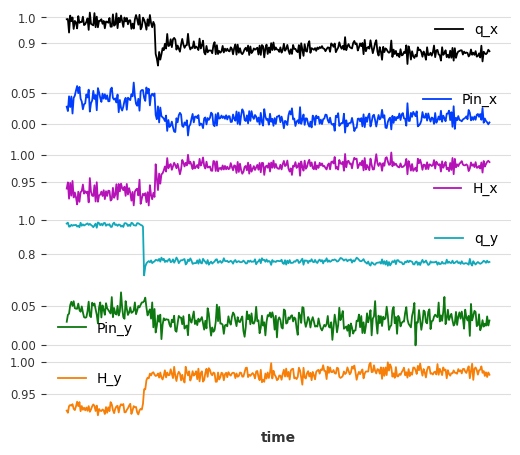

In [458]:
df_Model_BR = pred_series_BRNN.pd_dataframe()

df_Target = target_val_input.pd_dataframe()
df_Target 
#df_1 = df_Target.iloc[:10,:]
#df_2 = df_Target.iloc[10:,:]
#df_1.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_2 = pd.merge(df_Model_BR, df_Target, on ='time')
df_M_2.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_2.rename(columns = {'q_x': 'q_Pred', 'Pin_x': 'Pin_Pred', 'H_x': 'H_Pred', 'q_y': 'q_Val', 'Pin_y': 'Pin_Val', 'H_y': 'H_Val'}, inplace = True)
df_M_2['q_err'] = df_M_2['q_Pred'] - df_M_2['q_Val']
df_M_2['Pin_err'] = df_M_2['Pin_Pred'] - df_M_2['Pin_Val']
df_M_2['H_err'] = df_M_2['H_Pred'] - df_M_2['H_Val']
df_M_2 =  df_M_2.reset_index(drop=True)
df_M_2

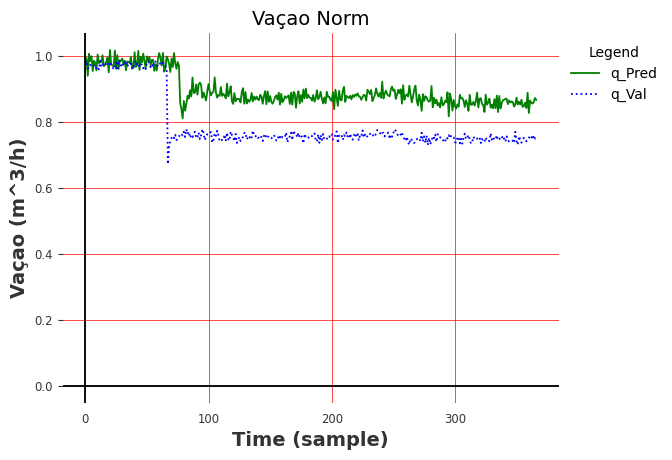

In [459]:
ndiv = 100
#plot each series
plt.plot(df_M_2['q_Pred'], label='q_Pred', color='green')
plt.plot(df_M_2['q_Val'], label='q_Val', color='blue', linestyle=':')
# adding title to the plot
plt.title('Vaçao Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (sample)',fontsize=14)
plt.ylabel('Vaçao (m^3/h)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

Erro Vazao

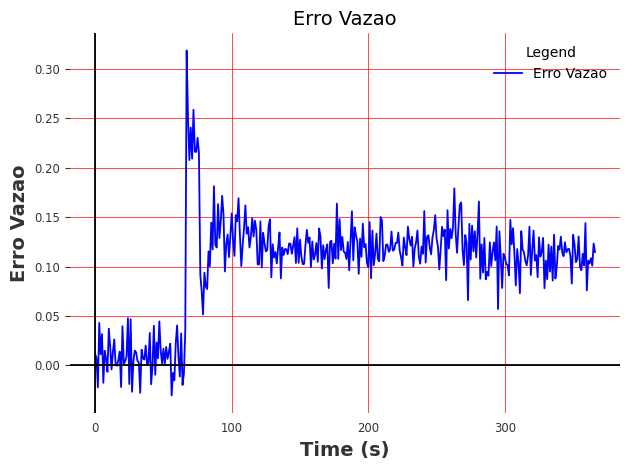

In [460]:
plt.plot(df_M_2['q_err'], label='Erro Vazao', color='blue')
# adding title to the plot
plt.title('Erro Vazao',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Vazao',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

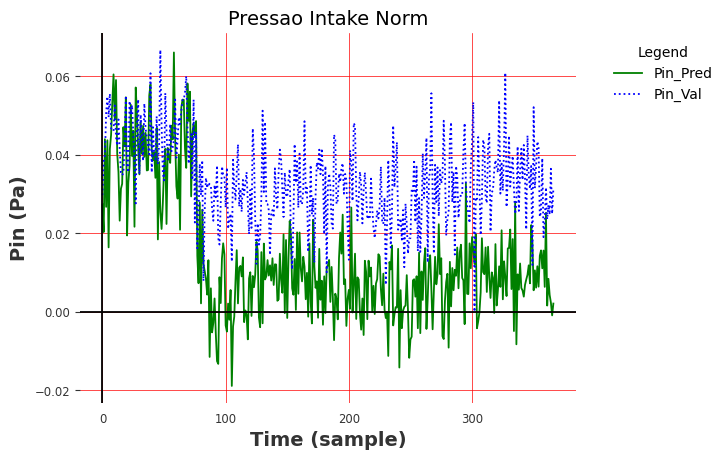

In [461]:
#plot each series
plt.plot(df_M_2['Pin_Pred'], label='Pin_Pred', color='green')
plt.plot(df_M_2['Pin_Val'], label='Pin_Val', color='blue',linestyle =':')
# adding title to the plot
plt.title('Pressao Intake Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (sample)',fontsize=14)
plt.ylabel('Pin (Pa)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.3,1))
plt.grid(color='r',  linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

Erro Pressao Intake

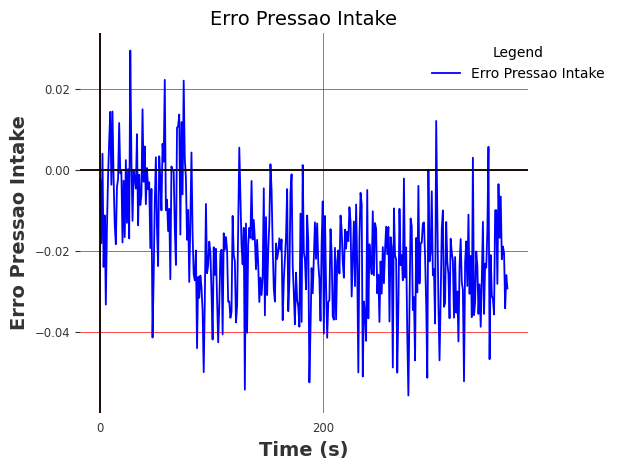

In [462]:
plt.plot(df_M_2['Pin_err'], label='Erro Pressao Intake', color='blue')
# adding title to the plot
plt.title('Erro Pressao Intake',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Pressao Intake',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), 200))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

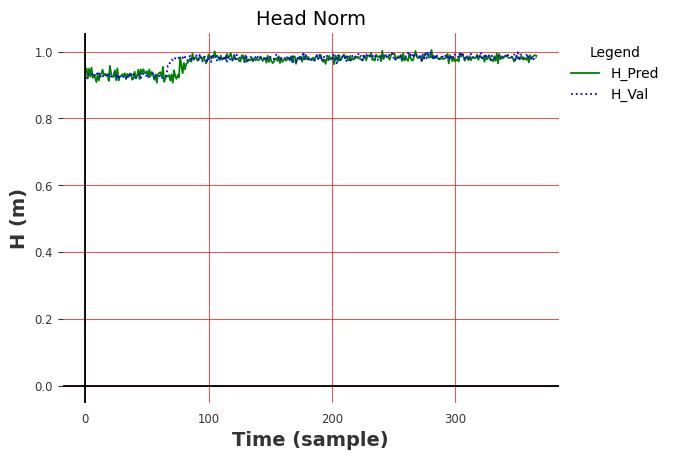

In [463]:
#plot each series
plt.plot(df_M_2['H_Pred'], label='H_Pred', color='green')
plt.plot(df_M_2['H_Val'], label='H_Val', color='blue',  linestyle=':')
# adding title to the plot
plt.title('Head Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (sample)',fontsize=14)
plt.ylabel('H (m)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

Erro Head

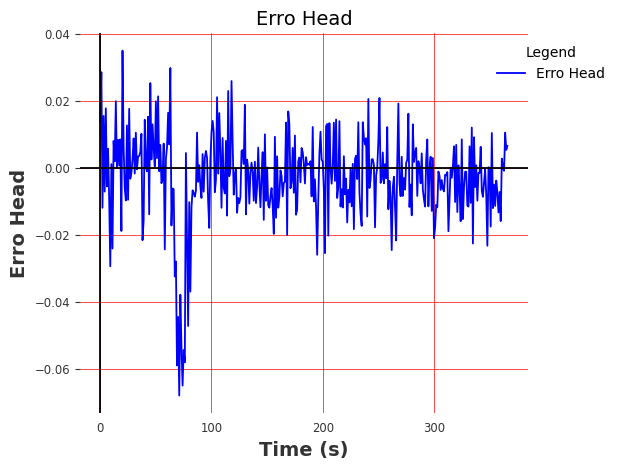

In [464]:
plt.plot(df_M_2['H_err'], label='Erro Head', color='blue')
# adding title to the plot
plt.title('Erro Head',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Head',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

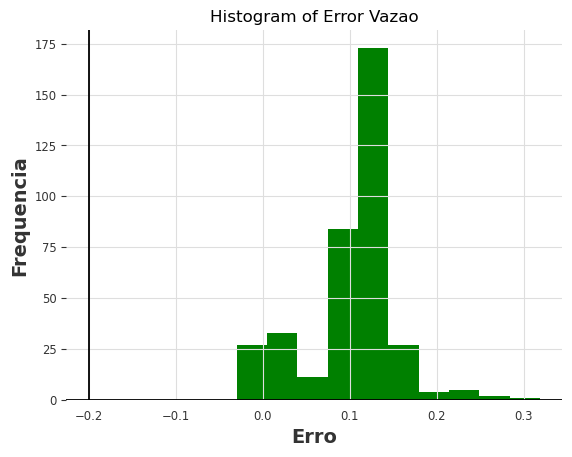

In [465]:
plt.hist(df_M_2['q_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Vazao')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.2) #y-axis line
plt.show() 

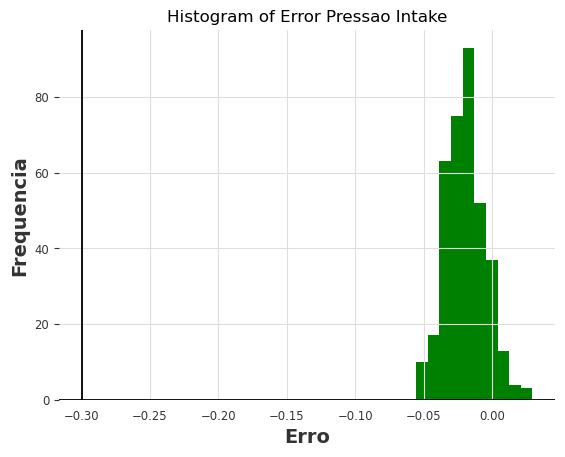

In [466]:
plt.hist(df_M_2['Pin_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Pressao Intake')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.3) #y-axis line
plt.show() 

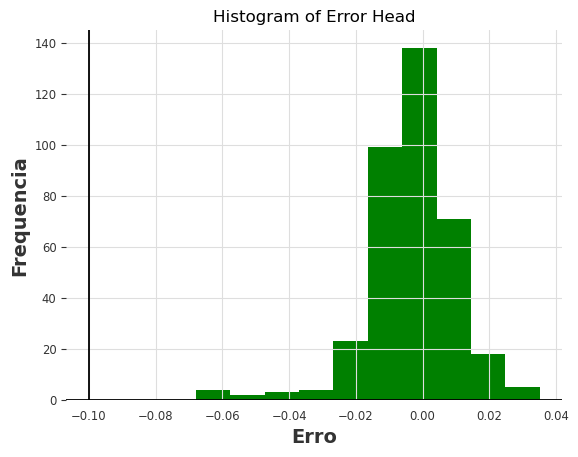

In [467]:
plt.hist(df_M_2['H_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Head')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.1) #y-axis line
plt.show() 

MODel TCM

In [415]:
model_RM = TCNModel.load("my_model_TCN_control_v3.pt")

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Backtest RMSE = 0.6061354263862709


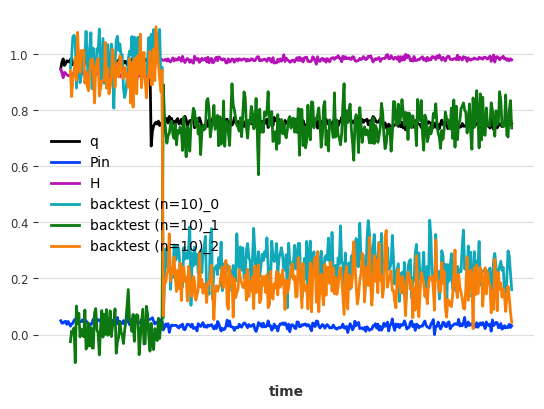

In [416]:
pred_series_TCNM = eval_model(model_RM)
#model_BRNN.extreme_lags

In [417]:
e7 = rmse(target_val_input, pred_series_TCNM)
print(e7)
e8 = mae( target_val_input, pred_series_TCNM)
print(e8)
e9 = r2_score(target_val_input, pred_series_TCNM)
print(e9)

0.6061354263862709
0.5478941562743959
-1536.8223032553178


component,q_Pred,Pin_Pred,H_Pred,q_Val,Pin_Val,H_Val,q_err,Pin_err,H_err
0,0.950484,-0.025276,0.941271,0.981376,0.029714,0.924193,-0.030893,-0.054990,0.017078
1,0.991020,0.012246,0.849162,0.986706,0.038321,0.920848,0.004314,-0.026075,-0.071687
2,1.061880,0.003422,0.910123,0.962814,0.039911,0.931237,0.099065,-0.036489,-0.021113
3,1.068358,0.023638,0.942180,0.964362,0.050614,0.933001,0.103997,-0.026976,0.009179
4,1.053705,-0.100433,0.988132,0.973946,0.054855,0.931952,0.079759,-0.155289,0.056180
...,...,...,...,...,...,...,...,...,...
362,0.206429,0.711342,0.131832,0.755773,0.027231,0.978613,-0.549344,0.684111,-0.846781
363,0.298559,0.704892,0.171543,0.747694,0.024750,0.984314,-0.449135,0.680142,-0.812771
364,0.280015,0.799089,0.132730,0.760218,0.036446,0.976953,-0.480202,0.762643,-0.844223
365,0.222321,0.834982,0.080643,0.749980,0.024965,0.984067,-0.527659,0.810017,-0.903423


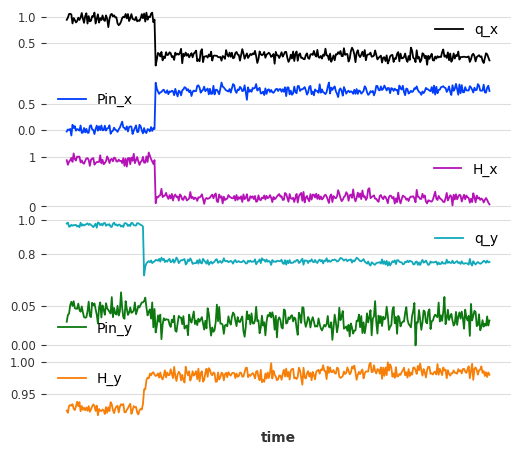

In [418]:
df_Model_TCNM = pred_series_TCNM.pd_dataframe()

df_Target = target_val_input.pd_dataframe()
df_Target 
#df_1 = df_Target.iloc[:10,:]
#df_2 = df_Target.iloc[10:,:]
#df_1.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_3 = pd.merge(df_Model_TCNM, df_Target, on ='time')
df_M_3.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_3.rename(columns = {'q_x': 'q_Pred', 'Pin_x': 'Pin_Pred', 'H_x': 'H_Pred', 'q_y': 'q_Val', 'Pin_y': 'Pin_Val', 'H_y': 'H_Val'}, inplace = True)
df_M_3['q_err'] = df_M_3['q_Pred'] - df_M_3['q_Val']
df_M_3['Pin_err'] = df_M_3['Pin_Pred'] - df_M_3['Pin_Val']
df_M_3['H_err'] = df_M_3['H_Pred'] - df_M_3['H_Val']
df_M_3 =  df_M_3.reset_index(drop=True)
df_M_3

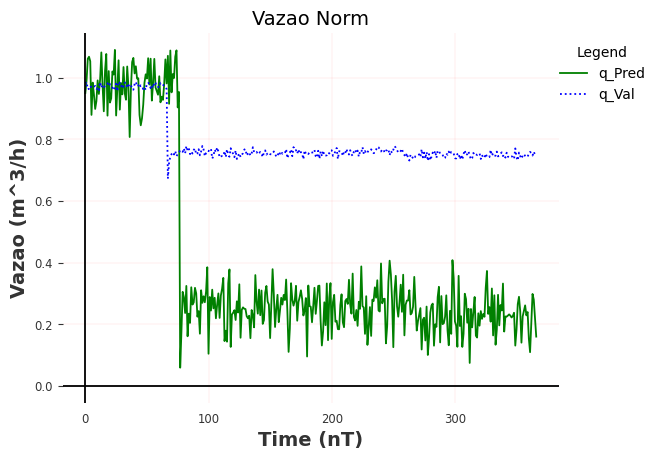

In [419]:
#plot each series
plt.plot(df_M_3['q_Pred'], label='q_Pred', color='green')
plt.plot(df_M_3['q_Val'], label='q_Val', color='blue', linestyle=':')
# adding title to the plot
plt.title('Vazao Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (nT)',fontsize=14)
plt.ylabel('Vazao (m^3/h)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
plt.grid(color='r',  linewidth=.05)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

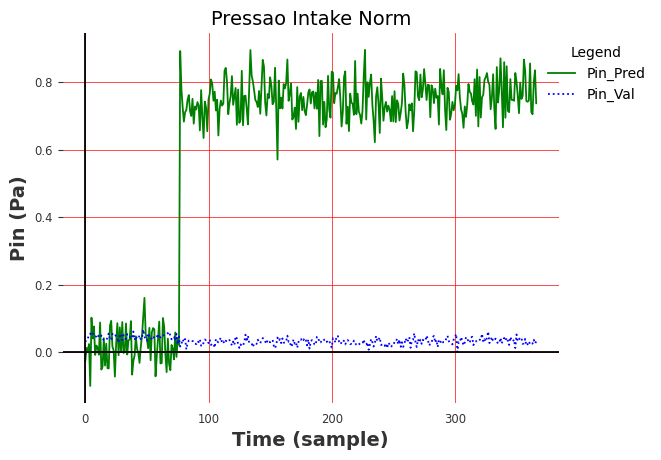

In [420]:
#plot each series
plt.plot(df_M_3['Pin_Pred'], label='Pin_Pred', color='green')
plt.plot(df_M_3['Pin_Val'], label='Pin_Val', color='blue', linestyle=':')
# adding title to the plot
plt.title('Pressao Intake Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (sample)',fontsize=14)
plt.ylabel('Pin (Pa)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

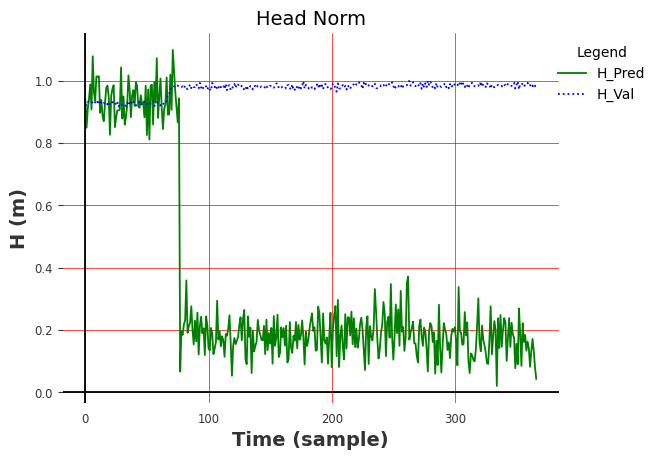

In [421]:
#plot each series
plt.plot(df_M_3['H_Pred'], label='H_Pred', color='green')
plt.plot(df_M_3['H_Val'], label='H_Val', color='blue', linestyle=':')
# adding title to the plot
plt.title('Head Norm',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (sample)',fontsize=14)
plt.ylabel('H (m)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_1), ndiv))
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

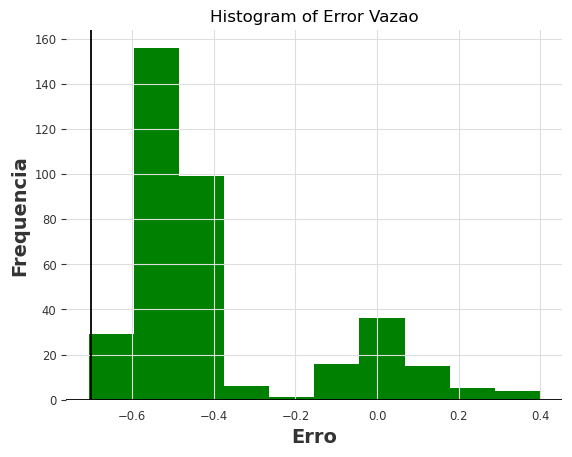

In [434]:
plt.hist(df_M_3['q_err'], label='Error_qred', color='green')
# the histogram of the data
plt.title('Histogram of Error Vazao')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.7) #y-axis line
plt.show() 

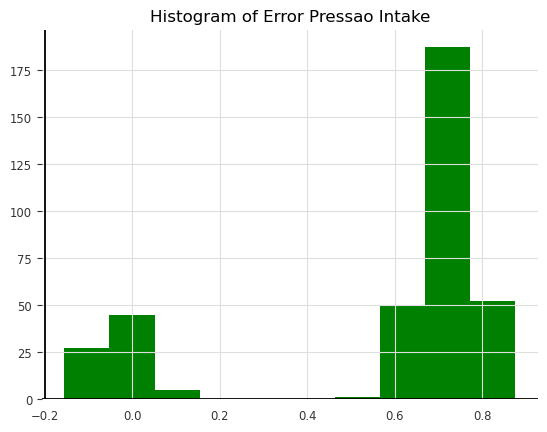

In [423]:
plt.hist(df_M_3['Pin_err'], label='Error_Pred', color='green')
# the histogram of the data
plt.title('Histogram of Error Pressao Intake')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-0.2) #y-axis line
plt.show() 

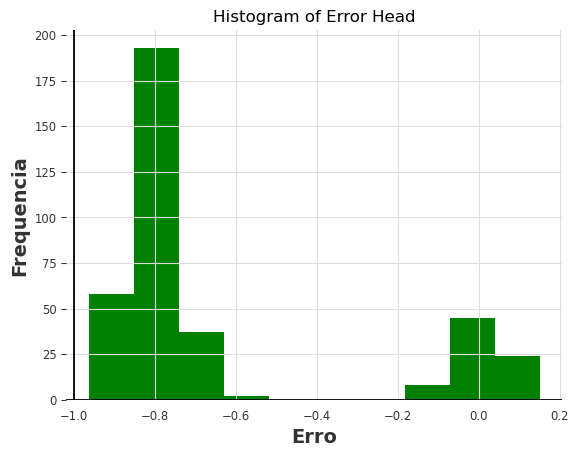

In [433]:
plt.hist(df_M_3['H_err'], label='Error_Hred', color='green')
# the histogram of the data
plt.title('Histogram of Error Head')
plt.xlabel('Erro',fontsize=14)
plt.ylabel('Frequencia',fontsize=14)
plt.grid(True)
plt.axhline(0) #x-axis line
plt.axvline(-1) #y-axis line
plt.show() 

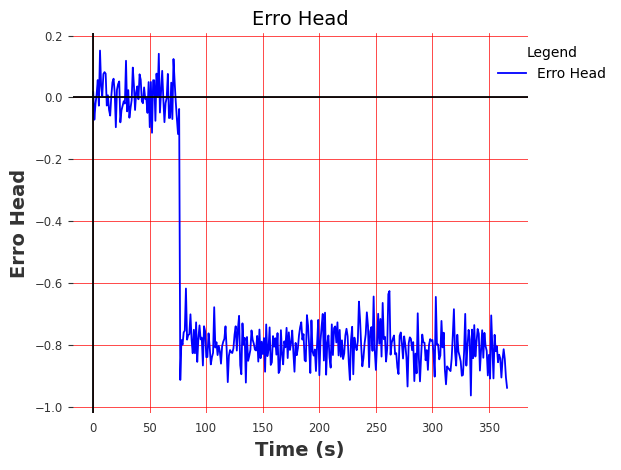

In [425]:
plt.plot(df_M_3['H_err'], label='Erro Head', color='blue')
# adding title to the plot
plt.title('Erro Head',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Head',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1.2,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_3), 50))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

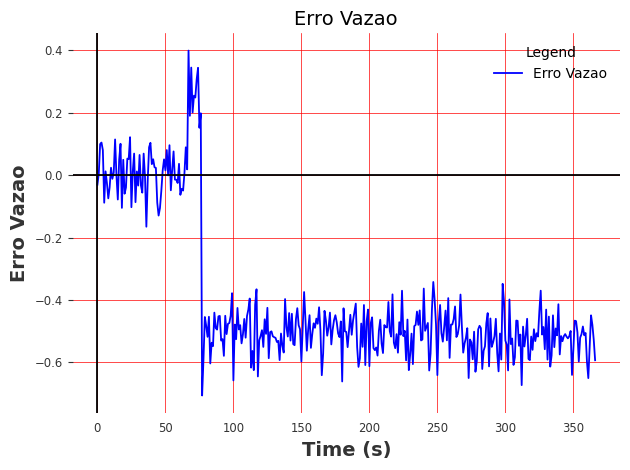

In [426]:
plt.plot(df_M_3['q_err'], label='Erro Vazao', color='blue')
# adding title to the plot
plt.title('Erro Vazao',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Vazao',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linestyle='-', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_3), 50))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

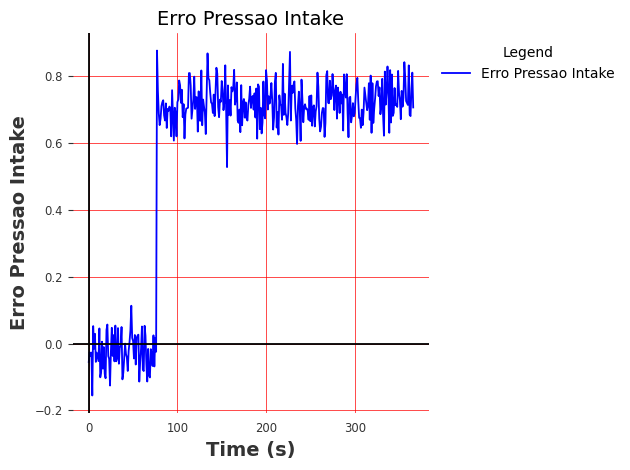

In [427]:
plt.plot(df_M_3['Pin_err'], label='Erro Pressao Intake', color='blue')
# adding title to the plot
plt.title('Erro Pressao Intake',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Erro Pressao Intake',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(df_M_2), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

Model Regresation

In [428]:
regr_model = RegressionModel.load("my_model_regression_14k.pkl")

Backtest RMSE = 0.3013390761086952


0.3013390761086952

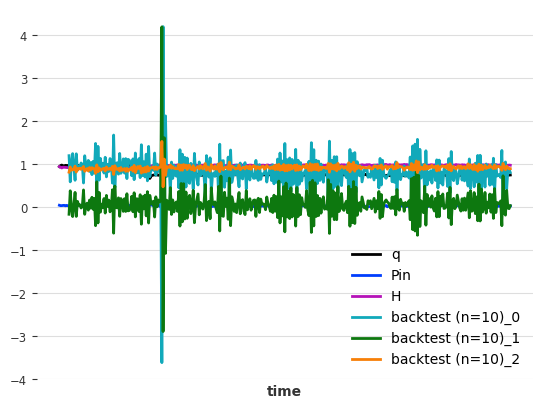

In [429]:
pred_series_regr = eval_model(regr_model)

#model_BRNN.extreme_lags
e2 = rmse(pred_series_regr, target_val_input)
e2

component,q_Pred,Pin_Pred,H_Pred,q_Val,Pin_Val,H_Val,q_err,Pin_err,H_err
0,1.202516,-0.159910,0.819212,0.981376,0.029714,0.924193,0.221140,-0.189624,-0.104981
1,0.593285,0.385860,0.939462,0.986706,0.038321,0.920848,-0.393420,0.347539,0.018614
2,1.022630,0.001838,0.864618,0.962814,0.039911,0.931237,0.059816,-0.038073,-0.066619
3,1.250017,-0.213341,0.883639,0.964362,0.050614,0.933001,0.285655,-0.263955,-0.049362
4,0.954088,0.053868,0.880487,0.973946,0.054855,0.931952,-0.019858,-0.000988,-0.051465
...,...,...,...,...,...,...,...,...,...
362,1.056286,-0.179845,0.877082,0.755773,0.027231,0.978613,0.300513,-0.207076,-0.101531
363,0.423908,0.394937,0.959138,0.747694,0.024750,0.984314,-0.323786,0.370187,-0.025176
364,0.876713,-0.016121,0.922100,0.760218,0.036446,0.976953,0.116495,-0.052567,-0.054853
365,0.890786,-0.029544,0.896508,0.749980,0.024965,0.984067,0.140806,-0.054509,-0.087559


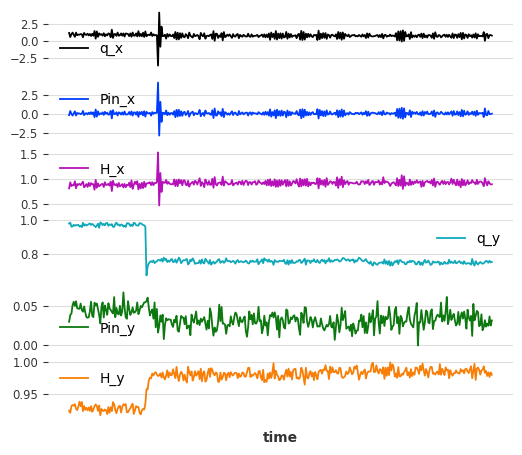

In [430]:
df_Model_regr = pred_series_regr.pd_dataframe()

df_Target = target_val_input.pd_dataframe()
df_Target 
#df_1 = df_Target.iloc[:10,:]
#df_2 = df_Target.iloc[10:,:]
#df_1.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_9 = pd.merge(df_Model_regr, df_Target, on ='time')
df_M_9.plot(subplots=True, figsize=(6, 6),x_compat=True)
df_M_9.rename(columns = {'q_x': 'q_Pred', 'Pin_x': 'Pin_Pred', 'H_x': 'H_Pred', 'q_y': 'q_Val', 'Pin_y': 'Pin_Val', 'H_y': 'H_Val'}, inplace = True)
df_M_9['q_err'] = df_M_9['q_Pred'] - df_M_9['q_Val']
df_M_9['Pin_err'] = df_M_9['Pin_Pred'] - df_M_9['Pin_Val']
df_M_9['H_err'] = df_M_9['H_Pred'] - df_M_9['H_Val']
df_M_9 =  df_M_9.reset_index(drop=True)
df_M_9

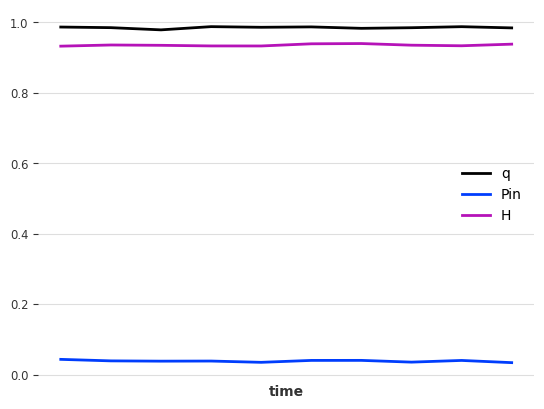

In [431]:
pred_series = model_NB.predict(n=10)
pred_series.plot()

if j > 10:
        df1 = df_Target[j-1]
        target = TimeSeries.from_dataframe(df1) 
        pred_series = model_RM.predict(n=10,series=target)
        df[j] = pred_series.pd_dataframe()
        df_Target[j] = data_val.iloc[:j,:]
        df_Target2[j]= data_val.iloc[j:,:]
        print(df1)  

K step TCM model

In [468]:
data_val = target_val_input.pd_dataframe()
df = {}
df_Target = {}
df_Target2 = {}
df_f_k = {}
df_f_k2 = covf_val_input.pd_dataframe()
df_Zc_k = {}
df_Zc_k2 = covZc_val_input.pd_dataframe()
k = round(100/10)
j = 0

for j in range(0, len(data_val), 10): 
    if j <= 40:
        #for TCM pred_series = model_RM.predict(n=10,series=target_train_input,  past_covariates= covf_train_input.stack(covZc_train_input))
        #for Brnn model_BRNN df_Target2[j] = data_val.iloc[j:j+10:]
        pred_series = model_BRNN.predict(n=10, series= target_train_input, past_covariates= covf_train_input.stack(covZc_train_input))
        df[j] = pred_series.pd_dataframe()
        df_Target[j] = data_val.iloc[:j,:]
        #df_Target2[j] = data_val.iloc[j:j+15,:]
        df_Target2[j] = data_val.iloc[j:j+30,:]
        df_f_k = df_f_k2.iloc[j:j+30,:]
        df_Zc_k = df_Zc_k2.iloc[j:j+30,:]   
        
    if j > 41:
        #For TCM
        # df1 = df_Target2[j-10]
        df1 = df_Target2[j-10]
        target = TimeSeries.from_dataframe(df1) 
        target_f = TimeSeries.from_dataframe(df_f_k)
        target_Zc = TimeSeries.from_dataframe(df_Zc_k)
        # pred_series = model_NB.predict(n=10, series=target)
        pred_series = model_BRNN.predict(n=10, series= target, past_covariates= target_f.stack(target_Zc))
        df[j] = pred_series.pd_dataframe()
        df_Target[j] = data_val.iloc[:j,:]
        #df_Target2[j] = data_val.iloc[j:j+15,:]
        df_Target2[j]= data_val.iloc[j:j+30,:]
        df_f_k = df_f_k2.iloc[j:j+30,:]
        df_Zc_k = df_Zc_k2.iloc[j:j+30,:]  
        
        print(df1)       


              
       

component                             q       Pin         H
time                                                       
1970-01-01 00:00:00.000000415  0.983639  0.044811  0.924479
1970-01-01 00:00:00.000000416  0.985193  0.038476  0.918863
1970-01-01 00:00:00.000000417  0.968109  0.053066  0.929681
1970-01-01 00:00:00.000000418  0.975938  0.046724  0.920817
1970-01-01 00:00:00.000000419  0.973212  0.044599  0.929426
1970-01-01 00:00:00.000000420  0.977848  0.042225  0.923385
1970-01-01 00:00:00.000000421  0.962095  0.040131  0.937481
1970-01-01 00:00:00.000000422  0.961373  0.060774  0.933958
1970-01-01 00:00:00.000000423  0.979287  0.035517  0.925010
1970-01-01 00:00:00.000000424  0.986883  0.047029  0.920201
1970-01-01 00:00:00.000000425  0.972523  0.040158  0.927043
1970-01-01 00:00:00.000000426  0.975865  0.038848  0.930736
1970-01-01 00:00:00.000000427  0.967463  0.049780  0.931794
1970-01-01 00:00:00.000000428  0.975498  0.037620  0.921233
1970-01-01 00:00:00.000000429  0.973990 

ValueError: All input series must have length >= `input_chunk_length` (20).

10

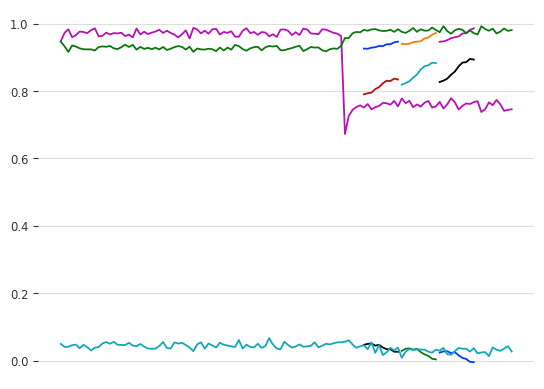

In [469]:
plt.plot(df[80])
plt.plot(df[70])
plt.plot(df[60])
plt.plot(df_Target[120])
len(df[10])

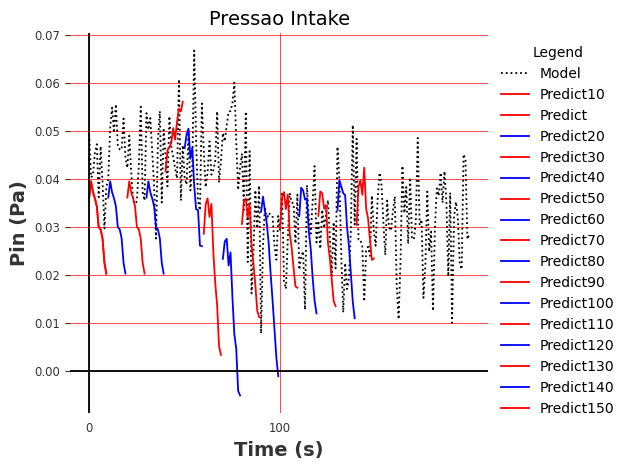

In [470]:
train_df1 = df_Target[200].copy()
train_df1 = train_df1.reset_index(drop=True)
df_pred1 = df[10].copy
df_pred1 = df[10].reset_index(drop=True)
df_pred2 = df[20].copy
df_pred2 = df[20].reset_index(drop=True)
df_pred3 = df[30].copy
df_pred3 = df[30].reset_index(drop=True)
df_pred4 = df[40].copy
df_pred4 = df[40].reset_index(drop=True)
df_pred5 = df[50].copy
df_pred5 = df[50].reset_index(drop=True)
df_pred6 = df[60].copy
df_pred6 = df[60].reset_index(drop=True)
df_pred7 = df[70].copy
df_pred7 = df[70].reset_index(drop=True)
df_pred8 = df[80].copy
df_pred8 = df[80].reset_index(drop=True)
df_pred9 = df[90].copy
df_pred9 = df[90].reset_index(drop=True)
df_pred10 = df[100].copy
df_pred10 = df[100].reset_index(drop=True)
df_pred11 = df[110].copy
df_pred11 = df[110].reset_index(drop=True)
df_pred12 = df[120].copy
df_pred12 = df[120].reset_index(drop=True)
df_pred13 = df[130].copy
df_pred13 = df[130].reset_index(drop=True)
df_pred14 = df[140].copy
df_pred14 = df[140].reset_index(drop=True)
df_pred15 = df[150].copy
df_pred15 = df[150].reset_index(drop=True)


#plot each series
plt.plot(train_df1['Pin'], label='Model', color='black', linestyle =':')
plt.plot(df_pred1['Pin'], label='Predict10', color='red')
plt.plot(np.arange(10),df_pred1['Pin'], label='Predict', color='red')
plt.plot(np.arange(10)+10,df_pred2['Pin'], label='Predict20', color='blue')
plt.plot(np.arange(10)+20,df_pred3['Pin'], label='Predict30', color='red')
plt.plot(np.arange(10)+30,df_pred4['Pin'], label='Predict40', color='blue')
plt.plot(np.arange(10)+40,df_pred5['Pin'], label='Predict50', color='red')
plt.plot(np.arange(10)+50,df_pred6['Pin'], label='Predict60', color='blue')
plt.plot(np.arange(10)+60,df_pred7['Pin'], label='Predict70', color='red')
plt.plot(np.arange(10)+70,df_pred8['Pin'], label='Predict80', color='blue')
plt.plot(np.arange(10)+80,df_pred9['Pin'], label='Predict90', color='red')
plt.plot(np.arange(10)+90,df_pred10['Pin'], label='Predict100', color='blue')
plt.plot(np.arange(10)+100,df_pred11['Pin'], label='Predict110', color='red')
plt.plot(np.arange(10)+110,df_pred12['Pin'], label='Predict120', color='blue')
plt.plot(np.arange(10)+120,df_pred13['Pin'], label='Predict130', color='red')
plt.plot(np.arange(10)+130,df_pred14['Pin'], label='Predict140', color='blue')
plt.plot(np.arange(10)+140,df_pred15['Pin'], label='Predict150', color='red')

# adding title to the plot
plt.title('Pressao Intake',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Pin (Pa)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(train_df1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

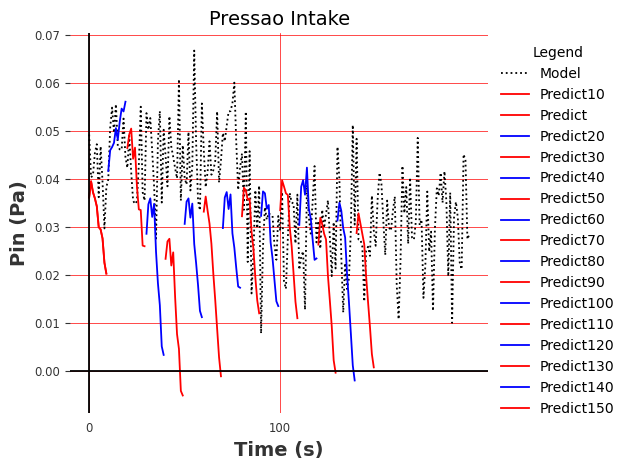

In [471]:
train_df1 = df_Target[200].copy()
train_df1 = train_df1.reset_index(drop=True)
df_pred1 = df[40].copy
df_pred1 = df[40].reset_index(drop=True)
df_pred2 = df[50].copy
df_pred2 = df[50].reset_index(drop=True)
df_pred3 = df[60].copy
df_pred3 = df[60].reset_index(drop=True)
df_pred4 = df[70].copy
df_pred4 = df[70].reset_index(drop=True)
df_pred5 = df[80].copy
df_pred5 = df[80].reset_index(drop=True)
df_pred6 = df[90].copy
df_pred6 = df[90].reset_index(drop=True)
df_pred7 = df[100].copy
df_pred7 = df[100].reset_index(drop=True)
df_pred8 = df[110].copy
df_pred8 = df[110].reset_index(drop=True)
df_pred9 = df[120].copy
df_pred9 = df[120].reset_index(drop=True)
df_pred10 = df[130].copy
df_pred10 = df[130].reset_index(drop=True)
df_pred11 = df[140].copy
df_pred11 = df[140].reset_index(drop=True)
df_pred12 = df[150].copy
df_pred12 = df[150].reset_index(drop=True)
df_pred13 = df[160].copy
df_pred13 = df[160].reset_index(drop=True)
df_pred14 = df[170].copy
df_pred14 = df[170].reset_index(drop=True)
df_pred15 = df[180].copy
df_pred15 = df[180].reset_index(drop=True)


#plot each series
plt.plot(train_df1['Pin'], label='Model', color='black', linestyle =':')
plt.plot(df_pred1['Pin'], label='Predict10', color='red')
plt.plot(np.arange(10),df_pred1['Pin'], label='Predict', color='red')
plt.plot(np.arange(10)+10,df_pred2['Pin'], label='Predict20', color='blue')
plt.plot(np.arange(10)+20,df_pred3['Pin'], label='Predict30', color='red')
plt.plot(np.arange(10)+30,df_pred4['Pin'], label='Predict40', color='blue')
plt.plot(np.arange(10)+40,df_pred5['Pin'], label='Predict50', color='red')
plt.plot(np.arange(10)+50,df_pred6['Pin'], label='Predict60', color='blue')
plt.plot(np.arange(10)+60,df_pred7['Pin'], label='Predict70', color='red')
plt.plot(np.arange(10)+70,df_pred8['Pin'], label='Predict80', color='blue')
plt.plot(np.arange(10)+80,df_pred9['Pin'], label='Predict90', color='red')
plt.plot(np.arange(10)+90,df_pred10['Pin'], label='Predict100', color='blue')
plt.plot(np.arange(10)+100,df_pred11['Pin'], label='Predict110', color='red')
plt.plot(np.arange(10)+110,df_pred12['Pin'], label='Predict120', color='blue')
plt.plot(np.arange(10)+120,df_pred13['Pin'], label='Predict130', color='red')
plt.plot(np.arange(10)+130,df_pred14['Pin'], label='Predict140', color='blue')
plt.plot(np.arange(10)+140,df_pred15['Pin'], label='Predict150', color='red')

# adding title to the plot
plt.title('Pressao Intake',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('Pin (Pa)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(train_df1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

In [ ]:
df_Target

In [ ]:
plt.plot(df[60])
len(df1)

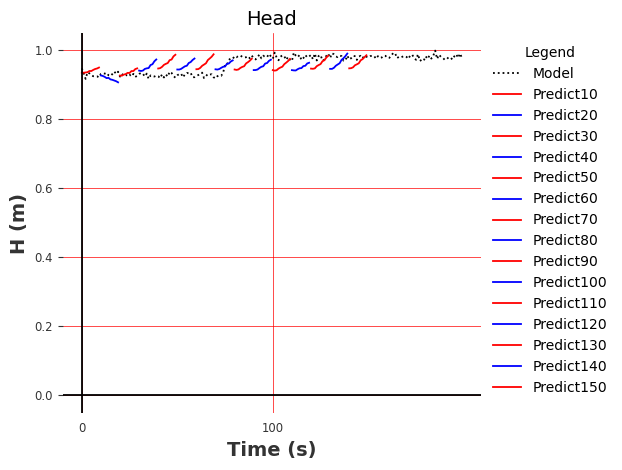

In [473]:

#plot each series
plt.plot(train_df1['H'], label='Model', color='black', linestyle =':')
plt.plot(df_pred1['H'], label='Predict10', color='red')
plt.plot(np.arange(10)+10,df_pred2['H'], label='Predict20', color='blue')
plt.plot(np.arange(10)+20,df_pred3['H'], label='Predict30', color='red')
plt.plot(np.arange(10)+30,df_pred4['H'], label='Predict40', color='blue')
plt.plot(np.arange(10)+40,df_pred5['H'], label='Predict50', color='red')
plt.plot(np.arange(10)+50,df_pred6['H'], label='Predict60', color='blue')
plt.plot(np.arange(10)+60,df_pred7['H'], label='Predict70', color='red')
plt.plot(np.arange(10)+70,df_pred8['H'], label='Predict80', color='blue')
plt.plot(np.arange(10)+80,df_pred9['H'], label='Predict90', color='red')
plt.plot(np.arange(10)+90,df_pred10['H'], label='Predict100', color='blue')
plt.plot(np.arange(10)+100,df_pred11['H'], label='Predict110', color='red')
plt.plot(np.arange(10)+110,df_pred12['H'], label='Predict120', color='blue')
plt.plot(np.arange(10)+120,df_pred13['H'], label='Predict130', color='red')
plt.plot(np.arange(10)+130,df_pred14['H'], label='Predict140', color='blue')
plt.plot(np.arange(10)+140,df_pred15['H'], label='Predict150', color='red')


# adding title to the plot
plt.title('Head',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (s)',fontsize=14)
plt.ylabel('H (m)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(train_df1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

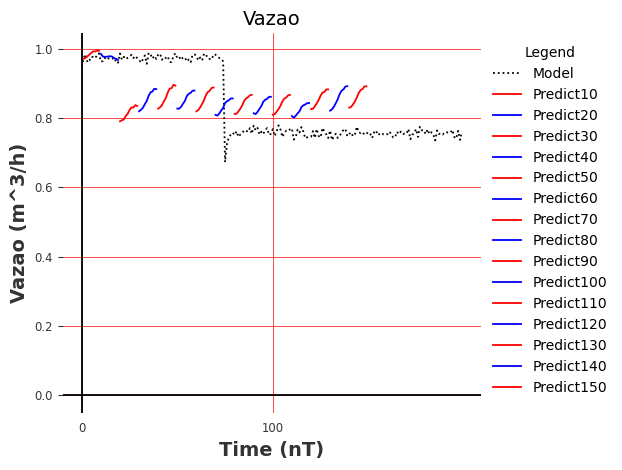

In [472]:
#plot each series
plt.plot(train_df1['q'], label='Model', color='black', linestyle =':')
plt.plot(df_pred1['q'], label='Predict10', color='red')
plt.plot(np.arange(10)+10,df_pred2['q'], label='Predict20', color='blue')
plt.plot(np.arange(10)+20,df_pred3['q'], label='Predict30', color='red')
plt.plot(np.arange(10)+30,df_pred4['q'], label='Predict40', color='blue')
plt.plot(np.arange(10)+40,df_pred5['q'], label='Predict50', color='red')
plt.plot(np.arange(10)+50,df_pred6['q'], label='Predict60', color='blue')
plt.plot(np.arange(10)+60,df_pred7['q'], label='Predict70', color='red')
plt.plot(np.arange(10)+70,df_pred8['q'], label='Predict80', color='blue')
plt.plot(np.arange(10)+80,df_pred9['q'], label='Predict90', color='red')
plt.plot(np.arange(10)+90,df_pred10['q'], label='Predict100', color='blue')
plt.plot(np.arange(10)+100,df_pred11['q'], label='Predict110', color='red')
plt.plot(np.arange(10)+110,df_pred12['q'], label='Predict120', color='blue')
plt.plot(np.arange(10)+120,df_pred13['q'], label='Predict130', color='red')
plt.plot(np.arange(10)+130,df_pred14['q'], label='Predict140', color='blue')
plt.plot(np.arange(10)+140,df_pred15['q'], label='Predict150', color='red')

# adding title to the plot
plt.title('Vazao',fontsize=14)
# adding Label to the x-axis
plt.xlabel('Time (nT)',fontsize=14)
plt.ylabel('Vazao (m^3/h)',fontsize=14)
# adding legend to the curve
plt.legend(title='Legend', bbox_to_anchor=(1,1))
#display plot
plt.grid(color='r', linewidth=.5)
# setting x-axis values
plt.xticks(np.arange(0, len(train_df1), 100))
plt.tight_layout()
plt.axhline(0) #x-axis line
plt.axvline(0) #y-axis line
plt.show()

Simulation for best fit
Verication of what time is better and how long